In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
df = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')

In [4]:
df

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


Lets start from some exploratory data analysis

In [5]:
total_images = df['ImageId'].nunique()
print(f'Total number of unique images: {total_images}')

Total number of unique images: 192556


There are more raws in the dataset as every ship detection location is in seperate raw and the same image can be in different raws for different ship coordiation masks.

In [6]:
# Number of images with ships
images_with_ships = df.dropna(subset=['EncodedPixels'])['ImageId'].nunique()
print(f'Number of images with ships: {images_with_ships}')

# Number of images without ships
images_without_ships = total_images - images_with_ships
print(f'Number of images without ships: {images_without_ships}')


Number of images with ships: 42556
Number of images without ships: 150000


In [7]:
# Number of ships
num_ships = df['EncodedPixels'].count()
print(f'Total number of ships across all images: {num_ships}')

Total number of ships across all images: 81723


Transforming a RLE code string into a list of pixels of a (768, 768) mask

In [8]:
def rle_to_pixels(rle_code):
    
    rle_code = [int(i) for i in rle_code.split()]
    pixels = [(pixel_position % 768, pixel_position // 768) 
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1::2])) 
                 for pixel_position in range(start, start + length)]
    return pixels

# drop rows with NaN EncodedPixels
ships = df.dropna(subset=['EncodedPixels'])

# add a new column "NumPixels" which will have the count of pixels for each ship
ships['NumPixels'] = ships['EncodedPixels'].apply(lambda x: len(rle_to_pixels(x)))

# calculate the average size of ships
avg_ship_size = ships['NumPixels'].mean()
print(f'Average ship size: {avg_ship_size} pixels')

# calculate the distribution of ship sizes
ship_size_dist = ships['NumPixels'].value_counts().sort_index()
print(f'Ship size distribution: \n{ship_size_dist}')


Average ship size: 1567.4028486472596 pixels
Ship size distribution: 
2        13
4        15
5         5
6         9
7        25
         ..
24214     1
24216     4
24599     2
25245     2
25904     2
Name: NumPixels, Length: 5429, dtype: int64


/tmp/ipykernel_28/3234004489.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ships['NumPixels'] = ships['EncodedPixels'].apply(lambda x: len(rle_to_pixels(x)))


Plot histogram for ship sizes

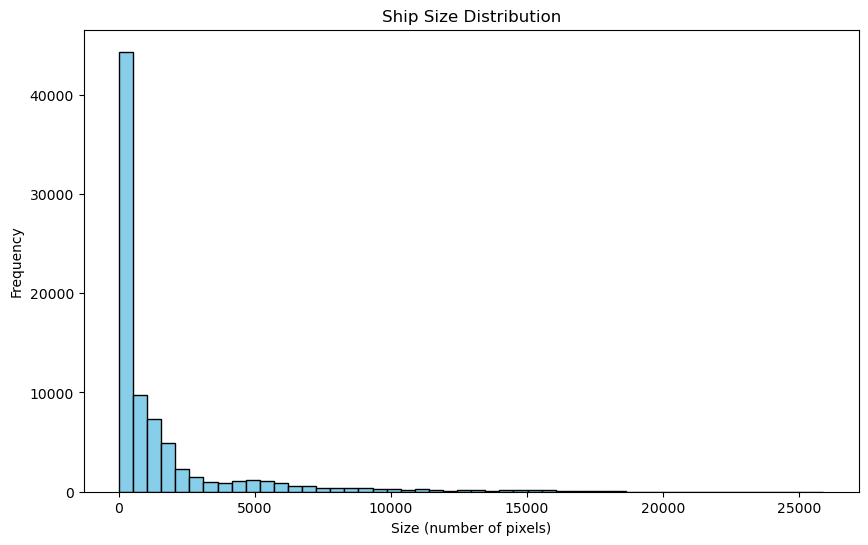

In [9]:
plt.figure(figsize=(10,6))
plt.hist(ships['NumPixels'], bins=50, color='skyblue', edgecolor='black')
plt.title('Ship Size Distribution')
plt.xlabel('Size (number of pixels)')
plt.ylabel('Frequency')
plt.show()

* mask_rle: run-length as string formatted (start length)
* shape: (height, width) of array to return 
* returning numpy array, 1 - mask, 0 - background

In [10]:
def rle_decode(mask_rle, shape=(768, 768)):

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def show_img_with_mask(img_id):
    '''Show image with mask for given image ID.'''
    img_path = f'/kaggle/input/airbus-ship-detection/train_v2/{img_id}'
    img = cv2.imread(img_path)

    img_masks = df.loc[df['ImageId'] == img_id, 'EncodedPixels'].tolist()

    # Create empty mask
    all_masks = np.zeros((768, 768))

    # If ship is present
    if img_masks[0] != img_masks[0]:
        # No ship in this image, just show the image
        plt.imshow(img)
        plt.show()
    else:
        # Ships are present, plot mask on image
        for mask in img_masks:
            all_masks += rle_decode(mask)
        
        fig, axarr = plt.subplots(1, 2, figsize=(15, 40))
        axarr[0].axis('off')
        axarr[1].axis('off')
        axarr[0].imshow(img)
        axarr[0].title.set_text('Image')
        axarr[1].imshow(img)
        axarr[1].imshow(all_masks, alpha=0.4, cmap='Reds')
        axarr[1].title.set_text('Image with mask')

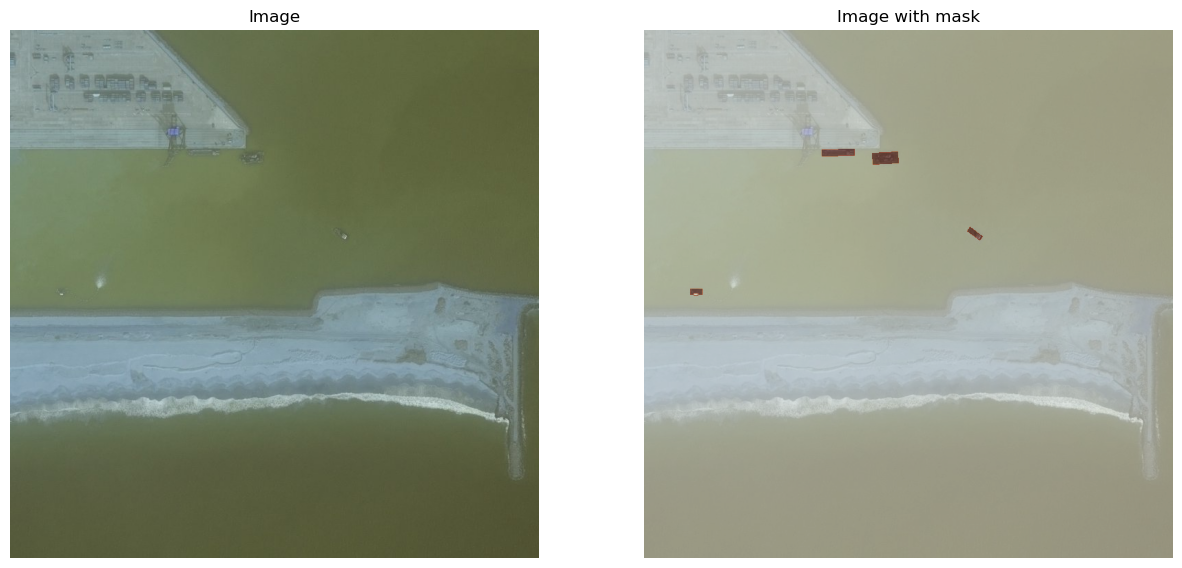

In [11]:
show_img_with_mask('000194a2d.jpg')

I created a visualization of the original image and the converted ship mask.

Splitting the dataset into training and validation 
But before lets take some part of the data

In [12]:
df = df.sample(n=5000, random_state=42)

In [13]:
from sklearn.model_selection import train_test_split

ships_df = df[df['EncodedPixels'].notnull()]

no_ships_df = df[df['EncodedPixels'].isnull()]

train_ships_df, valid_ships_df = train_test_split(ships_df, test_size=0.2, random_state=42)
train_no_ships_df, valid_no_ships_df = train_test_split(no_ships_df, test_size=0.2, random_state=42)

train_df = pd.concat([train_ships_df, train_no_ships_df])
valid_df = pd.concat([valid_ships_df, valid_no_ships_df])


In [15]:

from tensorflow.keras.preprocessing.image import img_to_array

from keras.utils import to_categorical

border = 5
im_chan = 3
n_classes = 2 

def preprocess_data(img_ids, img_dir, df, train=True):
    """This function preprocesses the image and mask data"""
    X = np.zeros((len(img_ids), 256, 256, im_chan), dtype=np.uint8)  # changed dimensions here
    y = np.zeros((len(img_ids), 256, 256, n_classes), dtype=np.uint8)  # changed dimensions here
    for n, id_ in enumerate(img_ids):

        img = cv2.imread(img_dir + id_)
        img = cv2.resize(img, (256, 256))  
        X[n] = img

        if train:

            mask = np.zeros((768, 768))
            masks = df.loc[df['ImageId'] == id_, 'EncodedPixels'].tolist()


            if masks[0] != masks[0]:

                pass
            else:
                for mask_ in masks:
                    mask += rle_decode(mask_)
            

            mask = cv2.resize(mask, (256, 256))  # added resizing here

            mask = np.expand_dims(mask, axis=-1)

            mask_cat = to_categorical(mask, num_classes=n_classes)

            y[n, ...] = mask_cat.squeeze()

    return X, y


img_dir = '/kaggle/input/airbus-ship-detection/train_v2/'


train_ids = train_df['ImageId'].values
valid_ids = valid_df['ImageId'].values


import os

if os.path.exists('X_train.npy') and os.path.exists('y_train.npy'):

    print("Loading data...")
    X_train = np.load('X_train.npy')
    y_train = np.load('y_train.npy')
else:

    print("Preprocessing data...")
    X_train, y_train = preprocess_data(train_ids, img_dir, train_df)


    print("Saving data...")
    np.save('X_train.npy', X_train)
    np.save('y_train.npy', y_train)


if os.path.exists('X_valid.npy') and os.path.exists('y_valid.npy'):
    print("Loading data...")
    X_valid = np.load('X_valid.npy')
    y_valid = np.load('y_valid.npy')
else:
    print("Preprocessing data...")
    X_valid, y_valid = preprocess_data(valid_ids, img_dir, valid_df)

    print("Saving data...")
    np.save('X_valid.npy', X_valid)
    np.save('y_valid.npy', y_valid)


Loading data...
Loading data...


In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate

def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom of the U-Net
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder
    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    # Final layer
    output = Conv2D(n_classes, (1, 1), activation='softmax')(conv7)

    model = Model(inputs=inputs, outputs=output)

    return model


In [17]:
from keras import backend as K
import tensorflow as tf

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [18]:
from tensorflow.keras.optimizers import Adadelta

input_shape = (256, 256, im_chan)
n_classes = 2  # number of classes (background and ship in your case)

model = build_unet(input_shape, n_classes)


opt = Adadelta(learning_rate=0.01, rho=0.95)

# adadelta optimizer rho = 0.95 

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[iou_coef])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001),
    ModelCheckpoint('model_best_checkpoint.h5', verbose=1, save_best_only=True)
]

history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=16,
                    epochs=15,
                    callbacks=callbacks)


Epoch 1/15
250/250 [==============================] - ETA: 0s - loss: 0.0291 - iou_coef: 0.9903
Epoch 1: val_loss improved from inf to 0.01210, saving model to model_best_checkpoint.h5
250/250 [==============================] - 212s 719ms/step - loss: 0.0291 - iou_coef: 0.9903 - val_loss: 0.0121 - val_iou_coef: 0.9969 - lr: 0.0100
Epoch 2/15
250/250 [==============================] - ETA: 0s - loss: 0.0106 - iou_coef: 0.9974
Epoch 2: val_loss improved from 0.01210 to 0.00967, saving model to model_best_checkpoint.h5
250/250 [==============================] - 180s 721ms/step - loss: 0.0106 - iou_coef: 0.9974 - val_loss: 0.0097 - val_iou_coef: 0.9971 - lr: 0.0100
Epoch 3/15
250/250 [==============================] - ETA: 0s - loss: 0.0092 - iou_coef: 0.9975
Epoch 3: val_loss improved from 0.00967 to 0.00878, saving model to model_best_checkpoint.h5
250/250 [==============================] - 181s 723ms/step - loss: 0.0092 - iou_coef: 0.9975 - val_loss: 0.0088 - val_iou_coef: 0.9972 - lr: 

In [ ]:
# Plot IoU over epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['iou_coef'])
plt.plot(history.history['val_iou_coef'])
plt.title('Model IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
def preprocess_test_data(img_ids, img_dir):
    """This function preprocesses the image data"""
    X = np.zeros((len(img_ids), 256, 256, im_chan), dtype=np.uint8)  # changed dimensions here

    for n, id_ in enumerate(img_ids):
        # Load image
        img = cv2.imread(img_dir + id_)
        img = cv2.resize(img, (256, 256))  
        X[n] = img

    return X


img_dir = '/kaggle/input/airbus-ship-detection/test_v2/'

test_ids = ['00c3db267.jpg'] 

X_test = preprocess_test_data(test_ids, img_dir)

predicted_segmentation = model.predict(X_test)

predicted_segmentation = (predicted_segmentation > 0.5).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(X_test[0])
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_segmentation[0, ..., 0], cmap='gray')  
plt.title('Predicted Segmentation')
plt.show()


In [ ]:
test_ids = ['00dc34840.jpg']  

X_test = preprocess_test_data(test_ids, img_dir)

predicted_segmentation = model.predict(X_test)

predicted_segmentation = (predicted_segmentation > 0.9).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(X_test[0])
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_segmentation[0, ..., 0], cmap='gray') 
plt.title('Predicted Segmentation')
plt.show()


In [ ]:
import PIL

In [ ]:
PIL.Image.open('/kaggle/input/airbus-ship-detection/test_v2/00dc34840.jpg').size